In [1]:
import pandas as pd 
import numpy as np
import scipy as sp
from scipy.stats import linregress
import glob, os, sys
import matplotlib.pyplot as plt
sys.path.append('../')
from ReadData import ReadFiles

In [2]:
path = r'data/*.csv'
files = glob.glob(path)
input_params = ['Material','Gage Diameter','Extensometer Gage Length','Final Gage Diameter','Rockwell Hardness','Rockwell Scale','(s)']

Dict = ReadFiles(files,input_params)

Failed to find parameter "Final Gage Diameter" in data/N02DBR_1.csv 
Make sure you spelled it right / it exists (it may     not)

Done :)
CSV labels are:  Index(['(s)', '(mm)', '(kN)', '(mm/mm)'], dtype='object')


### Question 1

In [3]:
def stress(data,r):
    rad = r
    return 1000*data / np.pi / (rad**2)

def get_xy(Dict,key):
    dt = Dict[key]['data']
    r = np.float64(Dict[key]['Gage Diameter'])/2
    x,y = dt[:,3],stress(dt[:,2],r)
    return x,y

def finish(name,leg=True):
    plt.grid()
    plt.xlabel('Engineering Strain [mm/mm]')
    plt.ylabel('Engineering Stress [MPa]')
    if leg:
        plt.legend()
    plt.savefig('plots/'+name+'.png',dpi=600)
    plt.show()

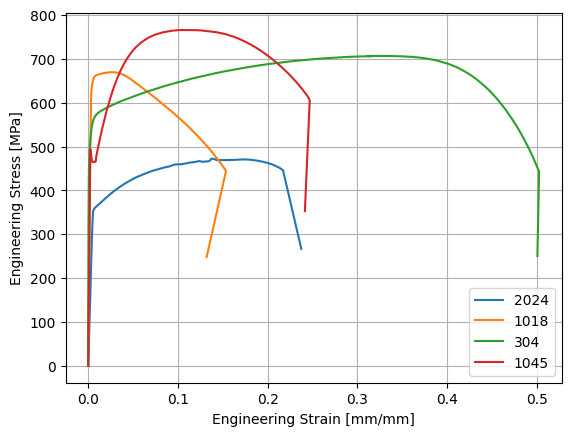

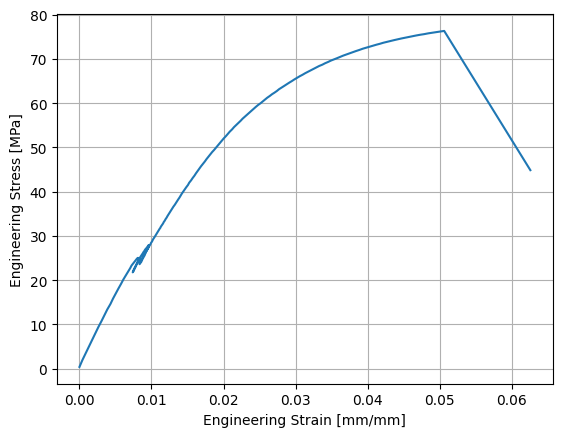

In [4]:
q1keys = [key for key in Dict.keys() if key != 'BR' and key != 'PMMA']

for key in q1keys:
    x,y = get_xy(Dict,key)
    plt.plot(x,y,label = key)
name = 'q1all'
finish(name)

x,y = get_xy(Dict,'PMMA')
name = 'q1_PMMA'
plt.plot(x,y)
finish(name,False)

### Question 2

In [5]:
def plote(x,y,bs,line=True):
    lb,ub = bs
    _x,_y = x[lb:ub],y[lb:ub]
    m = linregress(_x,_y).slope
    x2 = np.linspace(.002,.1,1000)
    b = -m*x2[0]
    if line:
        plt.plot(x2,m*x2+b)
        plt.grid()
    return m

In [6]:
# need E, .2, UTS, %elong, mod of resil, Rockwell

mat = [key for key in Dict.keys() if key!= 'BR']
hard_val = [np.float64(Dict[key]['Rockwell Hardness']) for key in Dict.keys() if key != 'BR']
hard_type = [Dict[key]['Rockwell Scale'] for key in Dict.keys() if key != 'BR']
elast_eps = [.007,.01554,.00518,.00278,.00429]
_2str = [359.4,42.7,649.8,525.3,465.8]
bounds=[[30,90],[0,20],[5,70],[5,80],[2,45]]
elast_mod = []
uts = []
per_elong = []


for k,bs in zip(mat,bounds):
    x,y = get_xy(Dict,k)
    m = plote(x,y,bs,False)
    elast_mod.append(m)
    uts.append(max(y))
    per_elong.append((max(x)-min(x))*100)

mod_resil = [s**2/2/e for s,e in zip(_2str,elast_mod)]

df = pd.DataFrame([elast_mod,_2str,uts,per_elong,mod_resil,hard_val])
df.columns = mat
df.index = ['E','2%offset','uts','percentelong','mod_resil','hardness']
df

,2024,PMMA,1018,304,1045
E,71795.198371,3150.347328,204335.730812,670381.193017,203454.927767
2%offset,359.400000,42.700000,649.800000,525.300000,465.800000
uts,472.552640,76.312833,669.533242,706.864084,765.946513
percentelong,23.751665,6.258399,15.360760,50.264967,24.690010
mod_resil,0.899561,0.289379,1.033202,0.205808,0.533213
hardness,72.800000,0.000000,94.300000,100.600000,90.700000


### Question 3

In [7]:
def q3plotter(y,savename,ylabel):
    x = hard_val
    m = mat
    for m,x,y in zip(m,x,y):
        plt.plot(x,y,'.',ms=10,label=m)
    plt.grid()
    plt.xlabel('Rockwell B Hardness')
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig('plots/'+savename+'.png',dpi=600)
    plt.show()

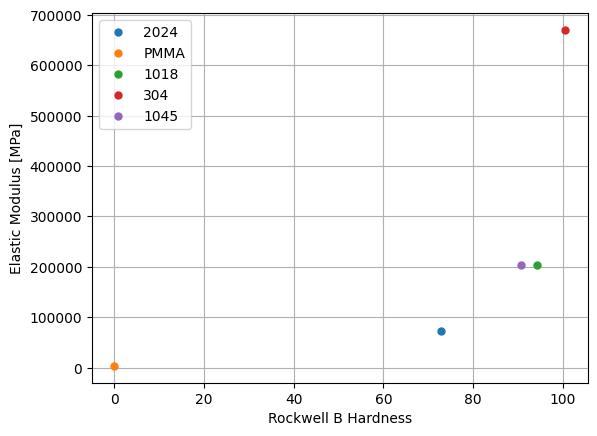

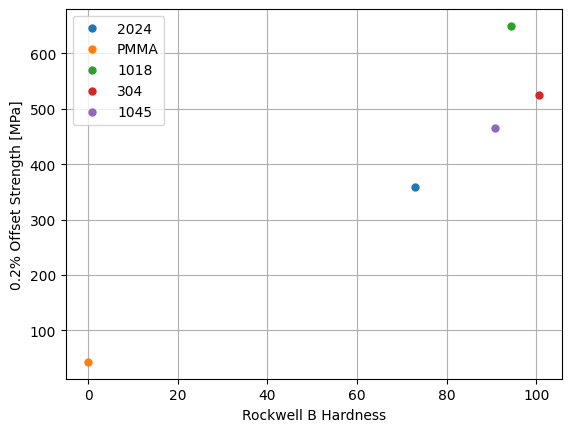

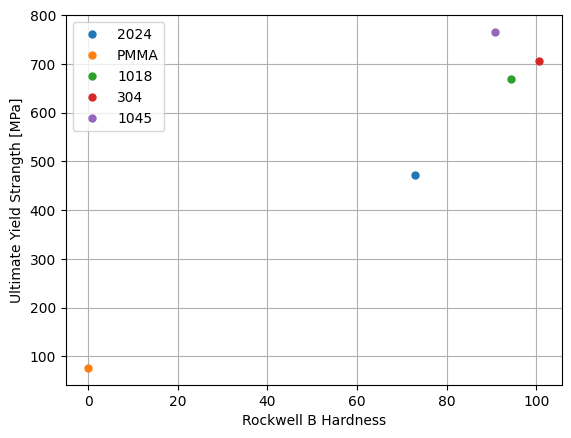

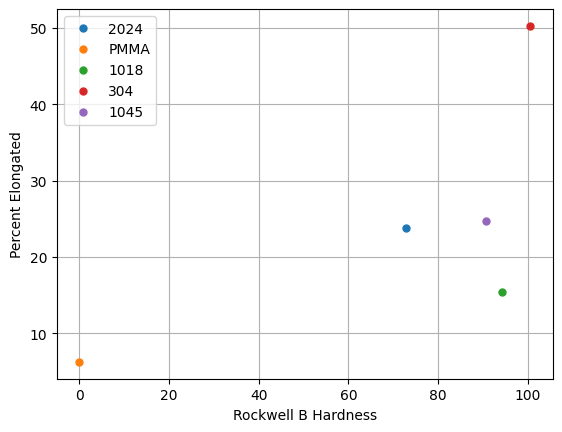

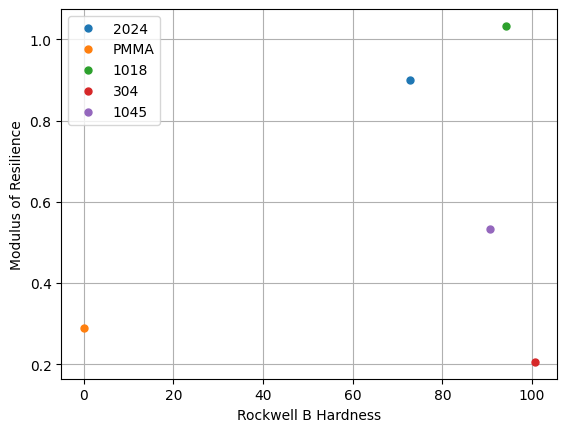

In [8]:
q3plotter(elast_mod,'q3_E','Elastic Modulus [MPa]')
q3plotter(_2str,'q3_offstr','0.2% Offset Strength [MPa]')
q3plotter(uts,'q3_uts','Ultimate Yield Strangth [MPa]')
q3plotter(per_elong,'q3_perelong','Percent Elongated')
q3plotter(mod_resil,'q3_resilmod','Modulus of Resilience')

### Question 4

In [9]:
def eng2tru(key):
    dt = Dict[key]['data']
    r = np.float64(Dict[key]['Gage Diameter'])/2
    x,y = dt[:,3],stress(dt[:,2],r)
    _x = np.log(1+x)
    _y = y*(1+x)
    return _x,_y,x,y

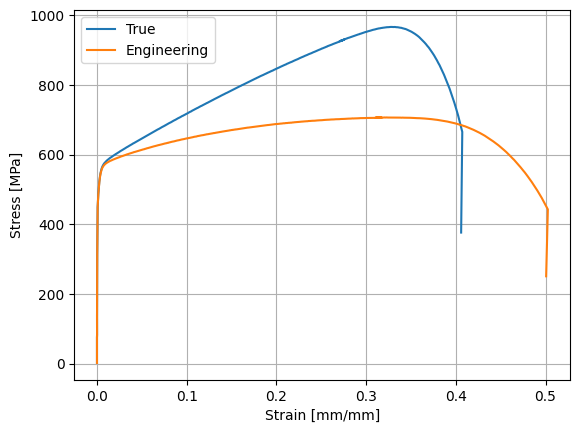

In [10]:
x,y,ex,ey = eng2tru('304')
plt.plot(x,y,label='True')
plt.plot(ex,ey,label='Engineering')
plt.grid()
plt.xlabel('Strain [mm/mm]')
plt.ylabel('Stress [MPa]')
plt.legend()
plt.savefig('plots/q4_evt.png',dpi=600)
plt.show()

### Question 5

In [11]:
def q5func(x,k,n):
    return k*x**n

def get_true(lb,ub):
    dt = Dict['304']['data']
    r = np.float64(Dict['304']['Gage Diameter'])/2
    return dt[:,3][lb:ub],stress(dt[:,2][lb:ub],r)

def get_closest(val,data):
    is_close = []
    for d in data:
        is_close.append(abs(data-val))
    is_close = np.array(is_close)
    return np.argmin(is_close)

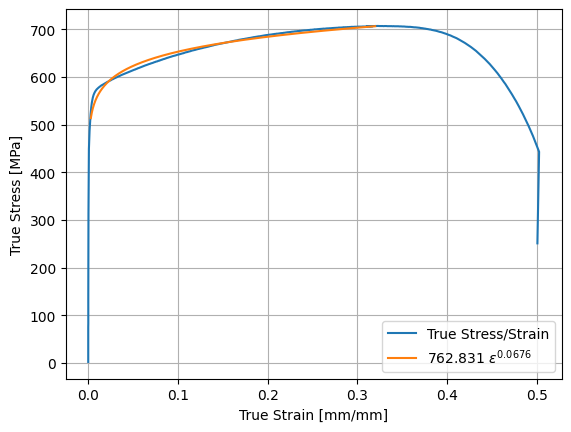

In [12]:
x,y = get_true(0,723)
_x,_y = get_true(get_closest(.00278,x),np.argmax(y))
plt.plot(x,y,label='True Stress/Strain')
K,n = sp.optimize.curve_fit(q5func,_x,_y)[0]
plt.plot(_x,q5func(_x,K,n),label='762.831 $\epsilon^{0.0676}$')
plt.grid()
plt.xlabel('True Strain [mm/mm]')
plt.ylabel('True Stress [MPa]')
plt.legend()
plt.savefig('plots/q5_fit.png',dpi=600)
plt.show()

### Question 6

In [48]:
def get_bronze():
    dt = Dict['BR']['data']
    r = np.float64(Dict['BR']['Gage Diameter'])/2
    x,y = dt[:,3],stress(dt[:,2],r)
    return x,y

In [83]:
x,y = get_bronze()
bs = [[0,70],[98,155],[240,320]]

slopes = []
strength = [292.9,321.1,367.7]

for lb,ub in bs:
    _x,_y = x[lb:ub],y[lb:ub]
    m = linregress(_x,_y).slope
    slopes.append(m)
    #x2 = np.linspace(min(_x)+.002, max(_x)+.01,1000)
    #plt.plot(x2,m*x2-x2[0]*m)
df = pd.DataFrame([slopes,strength])
df.index = ['Elastic Modulus','.2% offset strength']
df

,0,1,2
Elastic Modulus,52117.160275,55963.896776,46661.829922
.2% offset strength,292.900000,321.100000,367.700000


In [ ]:
[292.9,321.1,367.7]